In [29]:
import os

import numpy
from PIL import Image

from taiwan_license_plate_recognition.PostProcess import filter_license_number

In [30]:
%load_ext dotenv
%dotenv
%matplotlib inline

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [31]:
project_root: str = os.environ.get("PROJECT_ROOT", "")
test_image_path: str = f"{project_root}/datasets/ocr/電動車EWJ-8210.jpg"

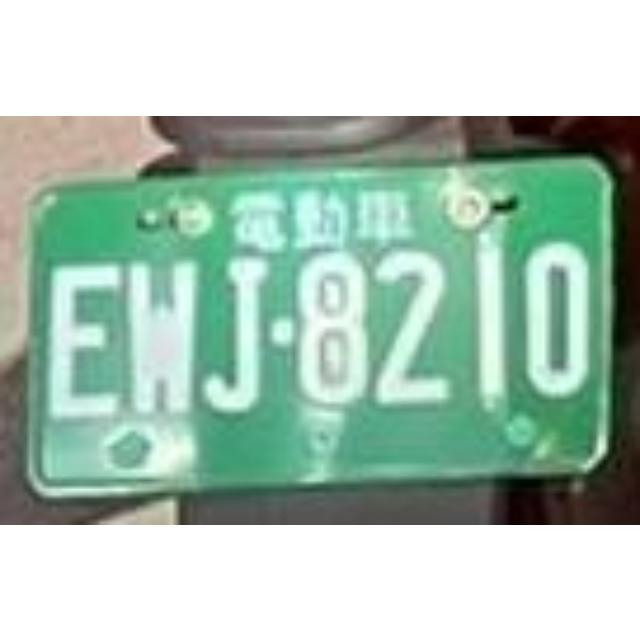

In [32]:
image = Image.open(test_image_path)
image

# EasyOCR

In [33]:
image.size

(640, 640)

In [34]:
import easyocr

In [35]:
reader = easyocr.Reader(["en"], gpu=False)

[2024-12-07 17:52:44,429] [ WARNING] easyocr.py:71 - Using CPU. Note: This module is much faster with a GPU.


## Use PIL format

In [36]:
result: str = reader.readtext(image)
result

[([[228, 179], [423, 179], [423, 263], [228, 263]],
  'Gmm',
  0.39145678738804424),
 ([[12, 191], [624, 191], [624, 445], [12, 445]],
  'Eljez10',
  0.4090924743156476)]

## Use picture directly

In [37]:
result = reader.readtext(test_image_path)
result

[([[223, 173], [423, 173], [423, 263], [223, 263]],
  'Gmm',
  0.27578614822276987),
 ([[12, 192], [625, 192], [625, 448], [12, 448]],
  'Elijezlo',
  0.40576345447817286)]

# PaddleOCR

In [38]:
from paddleocr import PaddleOCR

In [39]:
reader = PaddleOCR(lang="en", use_angle_cls=True, total_processes_num=8, binarize=True, device="cpu")

[2024/12/07 17:52:49] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/hermeschen/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/hermeschen/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, m

In [40]:
result = reader.ocr(numpy.asarray(image, dtype=numpy.uint8))

[2024/12/07 17:52:50] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1978309154510498
[2024/12/07 17:52:50] ppocr DEBUG: cls num  : 3, elapsed : 0.018326997756958008
[2024/12/07 17:52:50] ppocr DEBUG: rec_res num  : 3, elapsed : 0.22346210479736328


In [41]:
[(result[0][i][1][0]) for i in range(len(result[0]))]

['LO', 'EWJ-8210']

In [42]:
filter_license_number([(result[0][i][1][0]) for i in range(len(result[0]))])

'EWJ8210'

# Tesseract

In [43]:
import pytesseract

In [44]:
tesseract_config: str = "--psm 6 --oem 1"

In [45]:
result = pytesseract.image_to_string(image, lang="eng", config=tesseract_config)
result

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

# TrOCR

In [46]:
from optimum.intel import OVModelForVision2Seq
from transformers import TrOCRProcessor

In [47]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed", clean_up_tokenization_spaces=True)

In [48]:
model = OVModelForVision2Seq.from_pretrained(
	"DunnBC22/trocr-base-printed_license_plates_ocr", export=True, device="cpu"
)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

In [49]:
encode_image = processor(image.convert("RGB"), return_tensors="pt").pixel_values

In [50]:
generated_ids = model.generate(encode_image, max_length=20)

In [51]:
result = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
result

'8242ZQ'